In [4240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
from sklearn.metrics import r2_score
from io import StringIO
import glob
import os
import raytracing as rt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_widths
import scipy.optimize as spo
import scipy.constants as spc
import scipy.integrate as spi
import scipy.linalg as spl
import scipy.signal as spsi
import scipy.stats as spst

In [4241]:
def lire_csv(chemin_fichier):
    """
    Lecture d'un fichier CSV avec une première ligne à ignorer,
    et renvoie un DataFrame pandas.

    Args:
        chemin_fichier (str): Le chemin d'accès vers le fichier CSV.

    Returns:
        pandas.DataFrame: Un DataFrame pandas contenant les données du fichier CSV.
    """
    # Lire le fichier en ignorant la première ligne
    with open(chemin_fichier, 'r', encoding='utf-8') as fichier:
        lignes = fichier.readlines()[1:]  # Ignorer la première ligne
    
    # Préparer le contenu transformé
    contenu_transforme = []
    for ligne in lignes:
        partie_gauche, _, partie_droite = ligne.partition(', ')  # Séparer à la première virgule
        partie_gauche, partie_droite = partie_gauche.replace(',', '.'), partie_droite.replace(',', '.')   # Au cas où, mais devrait être inutile ici
        ligne_transformee = partie_gauche + ';' + partie_droite
        contenu_transforme.append(ligne_transformee)
    
    # Convertir le contenu transformé en un objet StringIO
    contenu_csv = StringIO(''.join(contenu_transforme))
    
    # Lire le contenu transformé en DataFrame
    df = pd.read_csv(contenu_csv, names=['Pixels', 'Value'],sep=";")
    return df

In [4242]:
def normalisation(df):
    """Fonction qui normalise les dataframes.

    Args:
        dataframe (DataFrame)

    Returns:
        DataFrame: Dataframe normalisé.
    """
    new_df = df.copy()
    column_name = new_df.columns[1]
    
    new_df[column_name] = (new_df[column_name]-min(new_df[column_name]))/np.ptp(new_df[column_name])
    
    return new_df

In [4243]:

def pixel_to_cm_normalise(df, factor=0.25):
    """
    Multiplies the first column of a 2-column DataFrame by a specified factor.
    
    Parameters:
    - df: A pandas DataFrame with exactly 2 columns.
    - factor: The factor by which to multiply the first column.
    
    Returns:
    - A new DataFrame with the first column values multiplied by the factor.
    """
    # Ensure the DataFrame has exactly 2 columns
    if len(df.columns) != 2:
        raise ValueError("The DataFrame must have exactly 2 columns")
    
    # Create a copy of the DataFrame to avoid modifying the original
    new_df = df.copy()
    
    # Multiply the first column by the factor
    first_column_name = new_df.columns[0]
    new_df[first_column_name] = new_df[first_column_name] * factor
    
    second_column_name = new_df.columns[1]
    new_df[second_column_name] = (new_df[second_column_name]-min(new_df[second_column_name]))/np.ptp(new_df[second_column_name])
    
    return new_df

In [4244]:
def find_peak_position(df, height_threshold=0.2):
    """
    Finds peaks based on the intensity column in a DataFrame, and calculates
    the mean position of these peaks.

    Parameters:
    - df: A pandas DataFrame with two columns, where the first column is 'position'
      and the second column is 'intensity'.
    
    Returns:
    - mean_peak_position: The mean position of the identified peaks.
    """
    # Identify peaks in the intensity column
    second_column_name = df.columns[1]
    peaks, _ = find_peaks(df[second_column_name],height=height_threshold)
    
    # Get the positions of these peaks
    first_column_name = df.columns[0]
    peak_positions = df.iloc[peaks][first_column_name]
    
    peak_width, peak_width_heigh, peak_width_left, peak_width_right = peak_widths(df[second_column_name],peaks,rel_height=height_threshold)
    
    return [np.array(peaks), np.array(peak_positions), np.array(df[second_column_name][peaks]), peak_width, peak_width_heigh, peak_width_left, peak_width_right]

In [4245]:
def find_all_index_of_peaks(df, height=0.2):
    peaks, peak_position, peaks_value, peak_width, peak_width_heigh, peak_width_left, peak_width_right = find_peak_position(df,height_threshold=height)
    
    peak_separer = []
    i = 0
    for peak in peak_width_left:
        position_interval = []
        for j in range(len(df)):
            if float(j) >= float(peak) and float(j) < float(peak) + float(peak_width[i]):
                position_interval += [j]
        peak_separer += [position_interval]
        i+=1
    
    return peak_separer

In [4246]:
def find_position_mean_std(df,echelle=0.025, height=0.2):
    
    peak_separer = find_all_index_of_peaks(df, height=height)
    moyennes = []
    stds = []
    for peak in peak_separer:
        moyennes += [np.mean(peak)]
        stds += [np.std(peak)]
        
    mean = []
    std = []
    for elem in moyennes :
        mean +=[elem * echelle]
    for elem in stds :
        std +=[elem * echelle]    
    return [mean, std]

In [4247]:
def find_intensity_mean_std(df,height=0.2,reverse=False):
    
    peak_separer = find_all_index_of_peaks(df, height=height)
    mean_intensity = []
    std_intensity = []
    
    for peak in peak_separer:
        intensity = []
        for elem in peak:
            intensity += [df.iloc[elem,1]]
        if reverse == True :
            for i in range(len(intensity)):
                intensity[i] = np.abs(intensity[i]-1)
        mean_intensity += [np.mean(intensity)]
        std_intensity += [np.std(intensity)]
            
    
    return [mean_intensity , std_intensity]

In [4248]:
def traitement_2d(df):
    second_column_name = df.columns[1]
    df[second_column_name] = np.abs(df[second_column_name]-1)
    return df

In [4249]:
def subset(minimum_peaks, indice=[0]):
    subset_value,subset_std  = [],[]
    for elem in indice:
        subset_value += [minimum_peaks[0][elem]]
        subset_std += [minimum_peaks[1][elem]]
    return subset_value, subset_std

In [4250]:
def mean_intensy_final(intensity,subsets):
    return [np.mean(subset(intensity,subsets)[0]),np.mean(subset(intensity,subsets)[1])]

In [ ]:
def MTF(max, min):
    return (max[0]-min[0])/(max[0]+min[0]), (max[1]+min[1])/

In [4251]:
def figure_plot_p4(df):
    mpl.figure(figsize=(12,6))
    mpl.plot(df["Pixels"],df["Value"], color="k")
    mpl.ylabel("Intensité normalisée [-]")
    mpl.xlabel("Position [mm]")
    # mpl.legend(frameon=False) 
    mpl.tick_params(axis='both', which='both', direction='in')
    mpl.minorticks_on()
    mpl.show()

# Données partie 4

## Données partie 4 x

In [4252]:
# Données 2D
partie4_2d_x = lire_csv(r"partie_4\partie4_2d_x.csv")

# Données avec filtre Ramlack
partie4_3d_040_025_ramlack_x = lire_csv(r"partie_4/partie4_3d_040_025_ramlack_x.csv")
partie4_3d_040_025_ramlack_x_v2 = lire_csv(r"partie_4\partie4_3d_040_025_ramlack_x_v2.csv")
partie4_3d_160_025_ramlack_x = lire_csv(r"partie_4\partie4_3d_160_025_ramlack_x.csv")

# Influence de la résolution : 0,25 ; 0,50 ; 2,00
partie4_3d_320_025_x = lire_csv(r"partie_4\partie4_3d_320_025_x.csv")
partie4_3d_320_050_x = lire_csv(r"partie_4\partie4_3d_320_050_x.csv")
partie4_3d_320_200_x = lire_csv(r"partie_4\partie4_3d_320_200_x.csv")

## Données partie 4 y

In [4253]:
# Données 2D
partie4_2d_y = traitement_2d(pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_2d_y.csv")))

# Données avec filtre Ramlack
partie4_3d_040_025_ramlack_y_v2 = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_040_025_ramlack_y_v2.csv"))
partie4_3d_040_025_ramlack_y = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_040_025_ramlack_y.csv"))
partie4_3d_160_025_ramlack_y = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_160_025_ramlack_y.csv"))

# Données avec diaphragme
partie4_3d_320_025_dia050_y = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_320_025_dia050_y.csv"))
partie4_3d_320_025_dia150_y = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_320_025_dia150_y.csv"))

# Données sans filtre
partie4_3d_320_025_nofilter_y = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_320_025_nofilter_y.csv"))

# Influence de la résolution : 0,25 ; 0,50 ; 2,00
partie4_3d_320_025_y = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_320_025_y.csv"))
partie4_3d_320_050_y = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_320_050_y.csv"),0.5)
partie4_3d_320_200_y = pixel_to_cm_normalise(lire_csv(r"partie_4\partie4_3d_320_200_y.csv"), 2)

# Graphiques

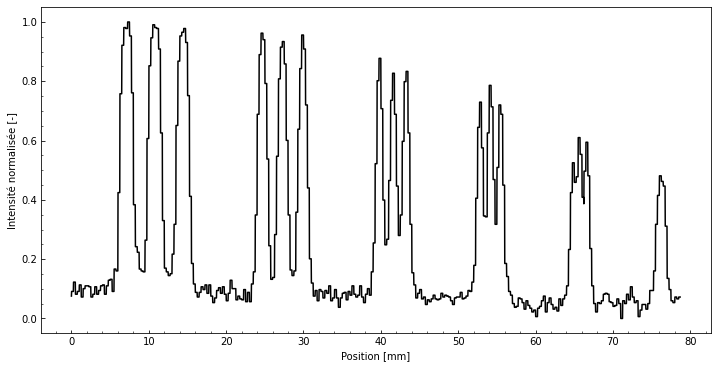

([7.1375, 10.762500000000001, 14.387500000000001, 24.762500000000003, 27.262500000000003, 29.887500000000003, 39.7625, 41.5125, 43.2625, 52.8875, 54.2625, 55.5125, 64.8875, 65.7625, 66.6375, 76.2625], [0.3607717422415453, 0.4329525570621644, 0.3607717422415453, 0.2885849095153799, 0.2885849095153799, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.14415703243338496, 0.07180703308172535, 0.2885849095153799])
([9.012500000000001, 12.637500000000001, 26.012500000000003, 28.637500000000003, 40.7625, 42.5125, 53.5125, 54.8875, 65.1375, 66.1375], [0.4329525570621644, 0.3607717422415453, 0.2885849095153799, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535])
([0.9666666666666666, 0.9428721174004193, 0.9389937106918239, 0.8962264150943395, 0.878930817610063, 0.9025157232704402, 0

In [4254]:
figure_plot_p4(partie4_2d_y)

position_max_partie4_2d_y = subset(find_position_mean_std(partie4_2d_y),[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
intensity_max_partie4_2d_y = subset(find_intensity_mean_std(partie4_2d_y),[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

reverse_partie4_2d_y = traitement_2d(partie4_2d_y)

position_min_partie4_2d_y = subset(find_position_mean_std(reverse_partie4_2d_y), [7,8,19,20,32,33,43,44,53,54])
intensity_min_partie4_2d_y = subset(find_intensity_mean_std(reverse_partie4_2d_y,reverse=True), [7,8,19,20,32,33,43,44,53,54])

print(position_max_partie4_2d_y)
print(position_min_partie4_2d_y)

print(intensity_max_partie4_2d_y)
print(intensity_min_partie4_2d_y)


intensity_max_groupe_1_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[0,1,2])
intensity_min_groupe_1_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[0,1])

intensity_max_groupe_2_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[3,4,5])
intensity_min_groupe_2_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[2,3])

intensity_max_groupe_3_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[6,7,8])
intensity_min_groupe_3_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[4,5])

intensity_max_groupe_4_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[9,10,11])
intensity_min_groupe_4_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[6,7])

intensity_max_groupe_5_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[12,13,14])
intensity_min_groupe_5_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[8,9])

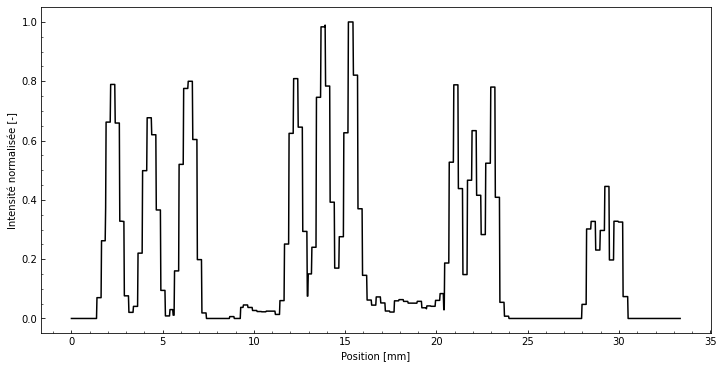

[[2.2625, 4.3875, 6.3875, 12.287500000000001, 13.787500000000001, 15.425, 21.0625, 22.0625, 23.087500000000002, 28.587500000000002, 29.337500000000002, 29.962500000000002], [0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.1513825177048746, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.14415703243338496]]
([3.2625, 5.3875, 13.037500000000001, 14.662500000000001, 21.5625, 22.5625, 28.837500000000002, 29.587500000000002], [0.21638603620997976, 0.2885849095153799, 0.07180703308172535, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535])
[[0.7035677530017156, 0.6482847341337913, 0.7878730703259021, 0.8089193825042887, 0.9841234991423677, 0.9145797598627787, 0.7879931389365342, 0.6334476843910795, 0.7804459691252157, 0.32737564322470003, 0.44535162950257445, 0.3265694682675816], [0.06063294440257505, 0.02862778730703258, 

In [4255]:
figure_plot_p4(partie4_3d_040_025_ramlack_y_v2)

position_max_partie4_3d_040_025_ramlack_y_v2 = find_position_mean_std(partie4_3d_040_025_ramlack_y_v2)
intensity_max_partie4_3d_040_025_ramlack_y_v2 = find_intensity_mean_std(partie4_3d_040_025_ramlack_y_v2)

reverse_partie4_3d_040_025_ramlack_y_v2 = traitement_2d(partie4_3d_040_025_ramlack_y_v2)
position_min_partie4_3d_040_025_ramlack_y_v2  = subset(find_position_mean_std(reverse_partie4_3d_040_025_ramlack_y_v2), [0,1,7,8,15,16,18,19])
intensity_min_partie4_3d_040_025_ramlack_y_v2  = subset(find_intensity_mean_std(partie4_3d_040_025_ramlack_y_v2,reverse=True), [0,1,7,8,15,16,18,19])

print(position_max_partie4_3d_040_025_ramlack_y_v2)
print(position_min_partie4_3d_040_025_ramlack_y_v2)

print(intensity_max_partie4_3d_040_025_ramlack_y_v2)
print(intensity_min_partie4_3d_040_025_ramlack_y_v2)

intensity_max_groupe_1_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_max_partie4_3d_040_025_ramlack_y_v2,[0,1,2])
intensity_min_groupe_1_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_min_partie4_3d_040_025_ramlack_y_v2,[0,1])

intensity_max_groupe_2_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_max_partie4_3d_040_025_ramlack_y_v2,[3,4,5])
intensity_min_groupe_2_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_min_partie4_3d_040_025_ramlack_y_v2,[2,3])

intensity_max_groupe_3_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_max_partie4_3d_040_025_ramlack_y_v2,[6,7,8])
intensity_min_groupe_3_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_min_partie4_3d_040_025_ramlack_y_v2,[4,5])

intensity_max_groupe_4_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_max_partie4_3d_040_025_ramlack_y_v2,[9,10,11])
intensity_min_groupe_4_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_min_partie4_3d_040_025_ramlack_y_v2,[6,7])

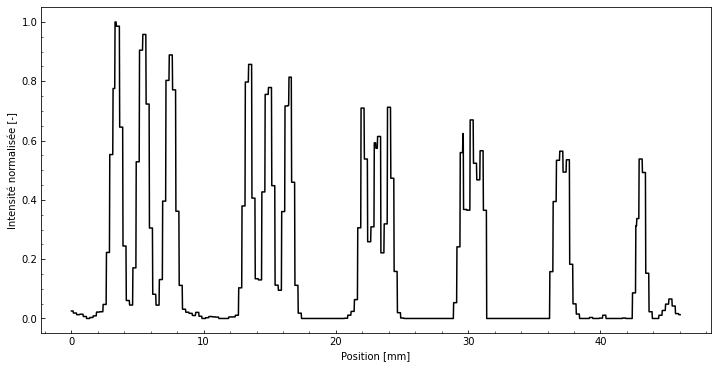

([3.4625000000000004, 5.3875, 7.5125, 13.387500000000001, 14.887500000000001, 16.3875, 22.012500000000003, 22.950000000000003, 24.012500000000003, 29.6125, 30.262500000000003, 31.012500000000003, 37.1625, 37.5375, 43.1625], [0.10077822185373186, 0.14415703243338496, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.03535533905932738, 0.07180703308172535, 0.0125, 0.07180703308172535, 0.07180703308172535, 0.2885849095153799, 0.07180703308172535, 0.14415703243338496])
([4.5125, 6.5125, 14.137500000000001, 15.637500000000001, 22.637500000000003, 23.637500000000003, 29.887500000000003, 30.762500000000003, 37.2875], [0.21638603620997976, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535])
([0.9898236568396713, 0.9314020895424615, 0.8209587440910918, 0.8271869780237759, 0.7673500802410509, 0.755769167785673, 0.70952739658

In [4256]:
figure_plot_p4(partie4_3d_160_025_ramlack_y)

position_max_partie4_3d_160_025_ramlack_y = subset(find_position_mean_std(partie4_3d_160_025_ramlack_y),[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15])
intensity_max_partie4_3d_160_025_ramlack_y = subset(find_intensity_mean_std(partie4_3d_160_025_ramlack_y),[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15])

reverse_partie4_3d_160_025_ramlack_y = traitement_2d(partie4_3d_160_025_ramlack_y)

position_min_partie4_3d_160_025_ramlack_y  = subset(find_position_mean_std(reverse_partie4_3d_160_025_ramlack_y), [2,3,7,8,10,12,14,15,17])
intensity_min_partie4_3d_160_025_ramlack_y  = subset(find_intensity_mean_std(partie4_3d_160_025_ramlack_y,reverse=True), [2,3,7,8,10,12,14,15,17])


print(position_max_partie4_3d_160_025_ramlack_y)
print(position_min_partie4_3d_160_025_ramlack_y)

print(intensity_max_partie4_3d_160_025_ramlack_y)
print(intensity_min_partie4_3d_160_025_ramlack_y)

intensity_max_groupe_1_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[0,1])

intensity_max_groupe_2_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_160_025_ramlack_yy = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[2,3])

intensity_max_groupe_3_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[4,5])

intensity_max_groupe_4_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[6,7])

intensity_max_groupe_5_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[12,13])
intensity_min_groupe_5_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[8])

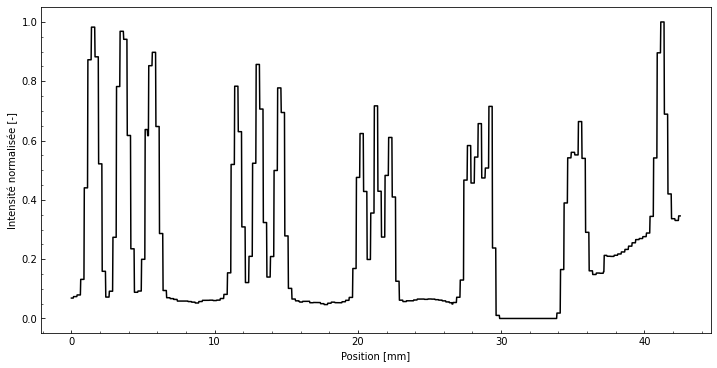

([1.5125000000000002, 3.6375, 5.6375, 11.512500000000001, 13.137500000000001, 14.637500000000001, 20.262500000000003, 21.262500000000003, 22.262500000000003, 27.762500000000003, 28.512500000000003, 29.262500000000003, 35.0125, 35.5125, 37.2875], [0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.057282196186948])
([2.5125, 4.6375, 12.387500000000001, 13.887500000000001, 20.762500000000003, 21.762500000000003, 28.012500000000003, 28.887500000000003, 35.2625], [0.21638603620997976, 0.2885849095153799, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.14415703243338496, 0.07180703308172535])
([0.9125066136087582, 0.9550311864255221, 0.875097806890077, 0.7833493550334225, 0.7815385303257257, 

In [4257]:
figure_plot_p4(partie4_3d_320_025_dia050_y)

position_max_partie4_3d_320_025_dia050_y = subset(find_position_mean_std(partie4_3d_320_025_dia050_y,height=0.2),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])
intensity_max_partie4_3d_320_025_dia050_y = subset(find_intensity_mean_std(partie4_3d_320_025_dia050_y,height=0.2),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])

reverse_partie4_3d_320_025_dia050_y = traitement_2d(partie4_3d_320_025_dia050_y)

position_min_partie4_3d_320_025_dia050_y  = subset(find_position_mean_std(reverse_partie4_3d_320_025_dia050_y,height=0.2), [0,1,6,7,12,13,18,19,21])
intensity_min_partie4_3d_320_025_dia050_y  = subset(find_intensity_mean_std(partie4_3d_320_025_dia050_y,height=0.2,reverse=True), [0,1,6,7,12,13,18,19,21])

print(position_max_partie4_3d_320_025_dia050_y)
print(position_min_partie4_3d_320_025_dia050_y)

print(intensity_max_partie4_3d_320_025_dia050_y)
print(intensity_min_partie4_3d_320_025_dia050_y)

intensity_max_groupe_1_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[0,1])

intensity_max_groupe_2_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[2,3])

intensity_max_groupe_3_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[4,5])

intensity_max_groupe_4_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[6,7])

intensity_max_groupe_5_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[12,13])
intensity_min_groupe_5_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[8])

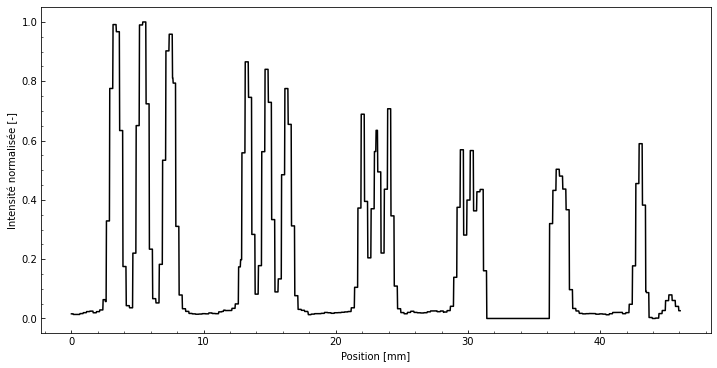

[[3.2625, 5.5125, 7.5125, 13.387500000000001, 14.887500000000001, 16.3875, 22.0375, 23.0375, 24.0375, 29.5375, 30.2875, 30.9125, 37.0375, 42.9375], [0.21638603620997976, 0.21638603620997976, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.14415703243338496, 0.3607717422415453, 0.14415703243338496]]
([4.3875, 6.3875, 14.012500000000001, 15.637500000000001, 22.5375, 23.5375, 29.7875, 30.5375], [0.2885849095153799, 0.2885849095153799, 0.21638603620997976, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535])
[[0.9113713298791014, 0.904614853195164, 0.8861126079447329, 0.8056373056994817, 0.7846217616580307, 0.7150362694300518, 0.6889119170984446, 0.5987461139896373, 0.7072331606217618, 0.568974093264248, 0.5663005181347153, 0.43124352331606197, 0.44372227979274603, 0.5222590673575123], [0.09641510

In [4258]:
figure_plot_p4(partie4_3d_320_025_dia150_y)

position_max_partie4_3d_320_025_dia150_y = find_position_mean_std(partie4_3d_320_025_dia150_y,height=0.3)
intensity_max_partie4_3d_320_025_dia150_y = find_intensity_mean_std(partie4_3d_320_025_dia150_y,height=0.3)

reverse_partie4_3d_320_025_dia150_y = traitement_2d(partie4_3d_320_025_dia150_y)

position_min_partie4_3d_320_025_dia150_y  = subset(find_position_mean_std(reverse_partie4_3d_320_025_dia150_y,height=0.3), [3,4,9,10,13,14,19,20])
intensity_min_partie4_3d_320_025_dia150_y  = subset(find_intensity_mean_std(partie4_3d_320_025_dia150_y,height=0.3,reverse=True), [3,4,9,10,13,14,19,20])


print(position_max_partie4_3d_320_025_dia150_y)
print(position_min_partie4_3d_320_025_dia150_y)

print(intensity_max_partie4_3d_320_025_dia150_y)
print(intensity_min_partie4_3d_320_025_dia150_y)

intensity_max_groupe_1_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia150_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_025_dia150_y= mean_intensy_final(intensity_min_partie4_3d_320_025_dia150_y,[0,1])

intensity_max_groupe_2_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia150_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia150_y,[2,3])

intensity_max_groupe_3_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia150_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia150_y,[4,5])

intensity_max_groupe_4_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia150_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia150_y,[6,7])

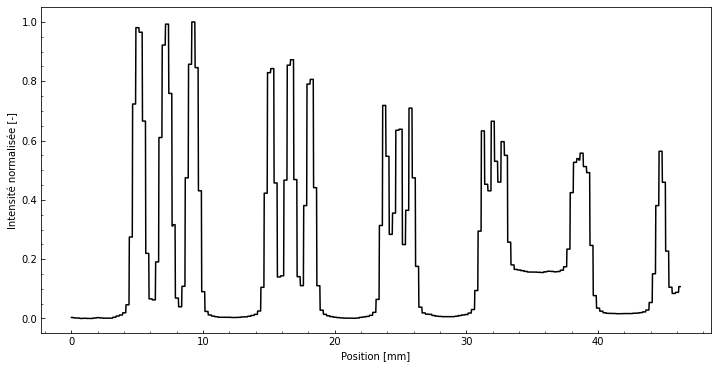

([5.1375, 7.1375, 9.262500000000001, 15.137500000000001, 16.6375, 18.1375, 23.762500000000003, 24.887500000000003, 25.762500000000003, 31.262500000000003, 32.0125, 32.7625, 38.462500000000006, 38.7625, 44.7625], [0.14415703243338496, 0.14415703243338496, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.04269562819149833, 0.3607717422415453, 0.07180703308172535])
([6.1375, 8.262500000000001, 15.887500000000001, 17.3875, 24.262500000000003, 25.262500000000003, 31.637500000000003, 32.5125, 38.587500000000006], [0.2885849095153799, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.14415703243338496, 0.07180703308172535, 0.027950849718747374])
([0.9731287863982795, 0.9573550350372704, 0.9011232399936723, 0.8358831904854963, 0.8634802758312616, 0.7984310003071002, 0.718501354

In [4259]:
figure_plot_p4(partie4_3d_320_025_nofilter_y)

position_max_partie4_3d_320_025_nofilter_y = subset(find_position_mean_std(partie4_3d_320_025_nofilter_y,height=0.2),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])
intensity_max_partie4_3d_320_025_nofilter_y = subset(find_intensity_mean_std(partie4_3d_320_025_nofilter_y,height=0.2),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])

reverse_partie4_3d_320_025_nofilter_y = traitement_2d(partie4_3d_320_025_nofilter_y)

position_min_partie4_3d_320_025_nofilter_y  = subset(find_position_mean_std(reverse_partie4_3d_320_025_nofilter_y,height=0.2), [3,5,8,9,11,12,15,16,20])
intensity_min_partie4_3d_320_025_nofilter_y  = subset(find_intensity_mean_std(partie4_3d_320_025_nofilter_y,height=0.2,reverse=True), [3,5,8,9,11,12,15,16,20])


print(position_max_partie4_3d_320_025_nofilter_y)
print(position_min_partie4_3d_320_025_nofilter_y)

print(intensity_max_partie4_3d_320_025_nofilter_y)
print(intensity_min_partie4_3d_320_025_nofilter_y)

intensity_max_groupe_1_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[0,1])

intensity_max_groupe_2_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[2,3])

intensity_max_groupe_3_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[4,5])

intensity_max_groupe_4_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[6,7])

intensity_max_groupe_5_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[12,13])
intensity_min_groupe_5_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[8])

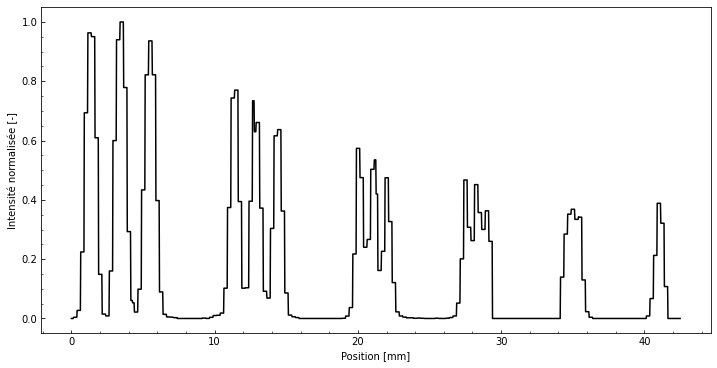

([1.3875000000000002, 3.3875, 5.5125, 11.387500000000001, 12.887500000000001, 14.387500000000001, 20.137500000000003, 21.075000000000003, 22.012500000000003, 27.512500000000003, 28.262500000000003, 29.012500000000003, 35.1375, 35.5125, 41.1375], [0.14415703243338496, 0.14415703243338496, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.10801234497346435, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.2885849095153799, 0.07180703308172535, 0.14415703243338496])
([2.3875, 4.5125, 12.137500000000001, 13.637500000000001, 20.637500000000003, 21.512500000000003, 28.012500000000003, 28.762500000000003, 35.2625], [0.2885849095153799, 0.21638603620997976, 0.14415703243338496, 0.14415703243338496, 0.14415703243338496, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535, 0.07180703308172535])
([0.956869078380706, 0.9700366063738152, 0.8599124318116572, 0.7568690783807073, 0.6714793281653747,

In [4260]:
figure_plot_p4(partie4_3d_320_025_y)

position_max_partie4_3d_320_025_y = subset(find_position_mean_std(partie4_3d_320_025_y,height=0.2),[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15])
intensity_max_partie4_3d_320_025_y = subset(find_intensity_mean_std(partie4_3d_320_025_y,height=0.2),[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15])

reverse_partie4_3d_320_025_y = traitement_2d(partie4_3d_320_025_y)

position_min_partie4_3d_320_025_y  = subset(find_position_mean_std(reverse_partie4_3d_320_025_y,height=0.2), [0,1,4,6,9,10,15,16,18])
intensity_min_partie4_3d_320_025_y = subset(find_intensity_mean_std(partie4_3d_320_025_y,height=0.2,reverse=True), [0,1,4,6,9,10,15,16,18])

print(position_max_partie4_3d_320_025_y)
print(position_min_partie4_3d_320_025_y)

print(intensity_max_partie4_3d_320_025_y)
print(intensity_min_partie4_3d_320_025_y)

intensity_max_groupe_1_partie4_3d_320_025_y = mean_intensy_final(intensity_max_partie4_3d_320_025_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_025_y= mean_intensy_final(intensity_min_partie4_3d_320_025_y,[0,1])

intensity_max_groupe_2_partie4_3d_320_025_y= mean_intensy_final(intensity_max_partie4_3d_320_025_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_025_y = mean_intensy_final(intensity_min_partie4_3d_320_025_y,[2,3])

intensity_max_groupe_3_partie4_3d_320_025_y = mean_intensy_final(intensity_max_partie4_3d_320_025_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_320_025_y = mean_intensy_final(intensity_min_partie4_3d_320_025_y,[4,5])

intensity_max_groupe_4_partie4_3d_320_025_y = mean_intensy_final(intensity_max_partie4_3d_320_025_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_320_025_y = mean_intensy_final(intensity_min_partie4_3d_320_025_y,[6,7])

intensity_max_groupe_5_partie4_3d_320_025_y = mean_intensy_final(intensity_max_partie4_3d_320_025_y,[12,13])
intensity_min_groupe_5_partie4_3d_320_025_y = mean_intensy_final(intensity_min_partie4_3d_320_025_y,[8])

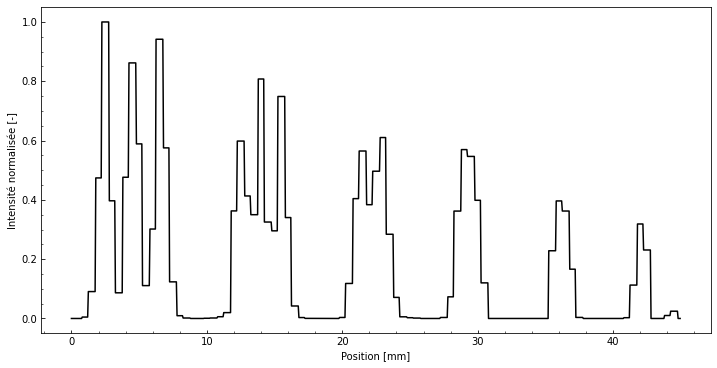

[[2.5, 4.5, 6.5, 12.5, 14.0, 15.5, 21.5, 23.0, 29.275000000000002, 36.275, 42.0], [0.158113883008419, 0.158113883008419, 0.158113883008419, 0.158113883008419, 0.12909944487358058, 0.158113883008419, 0.158113883008419, 0.12909944487358058, 0.2883140648667699, 0.2883140648667699, 0.12909944487358058]]
([3.5, 5.5, 13.5, 14.725000000000001, 22.0], [0.158113883008419, 0.158113883008419, 0.158113883008419, 0.2883140648667699, 0.12909944487358058])
[[1.0, 0.8619332829369466, 0.9417146401504166, 0.5983214126494953, 0.8076408675931874, 0.7486964780678796, 0.5647884320908695, 0.6102227132639434, 0.5569004283692909, 0.3776773080576078, 0.3186796146614723], [0.0, 1.1102230246251565e-16, 1.1102230246251565e-16, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.011465566307300125, 0.016923523018764177, 0.0]]
([0.08656548622821836, 0.11083328487526889, 0.350002907483864, 0.3118964548080097, 0.38372972030005303], [0.0, 0.0, 0.0, 0.014763483613520145, 0.0])


In [4261]:
figure_plot_p4(partie4_3d_320_050_y)


position_max_partie4_3d_320_050_y = find_position_mean_std(partie4_3d_320_050_y,echelle=0.05,height=0.1)
intensity_max_partie4_3d_320_050_y = find_intensity_mean_std(partie4_3d_320_050_y,height=0.1)

reverse_partie4_3d_320_050_y = traitement_2d(partie4_3d_320_050_y)


position_min_partie4_3d_320_050_y  = subset(find_position_mean_std(reverse_partie4_3d_320_050_y,echelle=0.05,height=0.1),[0,1,3,4,6])
intensity_min_partie4_3d_320_050_y = subset(find_intensity_mean_std(partie4_3d_320_050_y,height=0.1,reverse=True),[0,1,3,4,6])

print(position_max_partie4_3d_320_050_y)
print(position_min_partie4_3d_320_050_y)

print(intensity_max_partie4_3d_320_050_y)
print(intensity_min_partie4_3d_320_050_y)

intensity_max_groupe_1_partie4_3d_320_050_y = mean_intensy_final(intensity_max_partie4_3d_320_050_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_050_y = mean_intensy_final(intensity_min_partie4_3d_320_050_y,[0,1])

intensity_max_groupe_2_partie4_3d_320_050_y = mean_intensy_final(intensity_max_partie4_3d_320_050_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_050_y = mean_intensy_final(intensity_min_partie4_3d_320_050_y,[2,3])

intensity_max_groupe_3_partie4_3d_320_050_y = mean_intensy_final(intensity_max_partie4_3d_320_050_y,[6,7])
intensity_min_groupe_3_partie4_3d_320_050_y = mean_intensy_final(intensity_min_partie4_3d_320_050_y,[4])

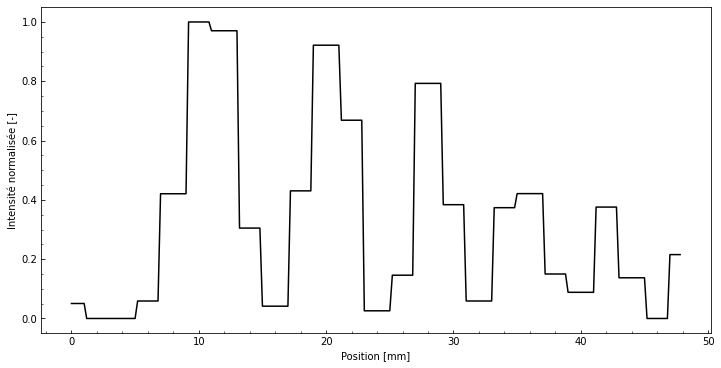

[[11.100000000000001, 20.0, 28.0, 35.1, 42.0], [1.1532562594670797, 0.632455532033676, 0.632455532033676, 1.1532562594670797, 0.5163977794943223]]


In [4262]:
figure_plot_p4(partie4_3d_320_200_y)
print(find_position_mean_std(partie4_3d_320_200_y,echelle=0.2))